# Pipeline
Created layers of piping
1. Data Types (categorical/numerical)
2. Combinging two types
3. Piping model

In [1]:
import numpy as np 
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import FeatureUnion, Pipeline 

#Custom Transformer that extracts columns passed as argument to its constructor 
class FeatureSelector( BaseEstimator, TransformerMixin ):
    #Class Constructor 
    def __init__( self, feature_names ):
        self._feature_names = feature_names 
    
    def fit( self, X, y = None ):
        return self 
    
    #Method that describes what we need this transformer to do
    def transform( self, X, y = None ):
        return X[ self._feature_names ]

Highly correlated data (>0.9) from correlation matrix

In [2]:
highly_correlated = ['Insurance_History_4','Insurance_History_7','Insurance_History_9', #category
 'Family_Hist_4', #numeric
 'Medical_History_26','Medical_History_36', #cat
 'Medical_Keyword_11','Medical_Keyword_23','Medical_Keyword_48'] #numeric

<b> Custom catgorical and numerical transformers

In [3]:
class CategoricalTransformer( BaseEstimator, TransformerMixin ):
    def __init__(self):
        pass
    
    def fit( self, X, y = None  ):
        return self
        
    #Transformer method we wrote for this transformer 
    def transform(self, X , y = None ):
        columns = list(X.columns)# since this is being fed all the categorical data, I can do this
        
        #Drop highly correlated
        drop_list = ['Insurance_History_4','Insurance_History_7','Insurance_History_9','Medical_History_26','Medical_History_36']
#         X.drop(drop_list,inplace = True, axis = 1)
        
#         for name in drop_list:
#             columns.remove(name)
#         Xfm = pd.get_dummies(data = X, columns = columns, prefix = columns,drop_first = True)
        Xfm = pd.get_dummies(X)
        
        return Xfm.values
#         return X[ self.feature_names ]    

In [4]:
#use .loc[row,indexer] instead of copying a slice
class NumericalTransformer(BaseEstimator, TransformerMixin):
    #Class Constructor
    def __init__( self, num_keywords = True, avg_family = True):
        self._num_keywords = num_keywords
        self.avg_family = avg_family
        
    #Return self, nothing else to do here
    def fit( self, X, y = None ):
        return self 
        
    #Custom transform method we wrote that creates aformentioned features and drops redundant ones 
    def transform(self, X, y = None): # X's type is a dataframe
        #feature engineering sum of keywords 
        if self._num_keywords:
            X.loc[:,'num_keywords'] = sum([X[column] for column in ['Medical_Keyword_' + str(i) for i in range(1,49)]])

    #family_hist_2 -> 5
        if self.avg_family: #will create columns with NaN from 0 + 0 + 0 + 0
            X.loc[:,'avg_family'] = X.loc[:,['Family_Hist_2','Family_Hist_3','Family_Hist_4','Family_Hist_5']].mean(axis = 1, skipna= True)
            X.drop(['Family_Hist_2','Family_Hist_3','Family_Hist_4','Family_Hist_5'],axis = 1, inplace = True)
        
        #solution to NaN value
        X.loc[:,'avg_family'] = np.where(X.loc[:,'avg_family'].isna(),0.5,X.loc[:,'avg_family'])
        
        #imput employment info and insurance history 5 using mean
        for column in ['Employment_Info_1','Employment_Info_4','Employment_Info_6','Insurance_History_5']:
            conditions = [ X.loc[:,column].isnull() ]
            out = [X.loc[:,column].mean()]
            X.loc[:,column] = np.select(conditions,out,X.loc[:,column])
            
        #fill in nan-vales with 0 in keywords and drop highly correlated
        X.fillna(0,inplace = True)
        X.drop(['Medical_Keyword_11','Medical_Keyword_23','Medical_Keyword_48'],inplace = True, axis = 1)

        return X.values


In [5]:
cats = 'Product_Info_1, Product_Info_2, Product_Info_3, Product_Info_5, Product_Info_6, Product_Info_7, Employment_Info_2, Employment_Info_3, Employment_Info_5, InsuredInfo_1, InsuredInfo_2, InsuredInfo_3, InsuredInfo_4, InsuredInfo_5, InsuredInfo_6, InsuredInfo_7, Insurance_History_1, Insurance_History_2, Insurance_History_3, Insurance_History_4, Insurance_History_7, Insurance_History_8, Insurance_History_9, Family_Hist_1, Medical_History_2, Medical_History_3, Medical_History_4, Medical_History_5, Medical_History_6, Medical_History_7, Medical_History_8, Medical_History_9, Medical_History_11, Medical_History_12, Medical_History_13, Medical_History_14, Medical_History_16, Medical_History_17, Medical_History_18, Medical_History_19, Medical_History_20, Medical_History_21, Medical_History_22, Medical_History_23, Medical_History_25, Medical_History_26, Medical_History_27, Medical_History_28, Medical_History_29, Medical_History_30, Medical_History_31, Medical_History_33, Medical_History_34, Medical_History_35, Medical_History_36, Medical_History_37, Medical_History_38, Medical_History_39, Medical_History_40, Medical_History_41'.split(', ')
cont = 'Product_Info_4, Ins_Age, Ht, Wt, BMI, Employment_Info_1, Employment_Info_4, Employment_Info_6, Insurance_History_5, Family_Hist_2, Family_Hist_3, Family_Hist_4, Family_Hist_5'.split(', ')
disc = 'Medical_History_1, Medical_History_10, Medical_History_15, Medical_History_24, Medical_History_32'.split(', ')

<b> Combining selections

In [6]:
#Categrical features to pass down the categorical pipeline 
categorical_features = cats

#Numerical features to pass down the numerical pipeline 
numerical_features = ['Medical_Keyword_' + str(i) for i in range(1,49)] + cont + disc

#Defining the steps in the categorical pipeline 
categorical_pipeline = Pipeline( steps = [ ( 'cat_selector', FeatureSelector(categorical_features) ), 
                                          
                                  ( 'cat_transformer', CategoricalTransformer() ), 
                                                                           ] )
#Defining the steps in the numerical pipeline     
numerical_pipeline = Pipeline( steps = [ ( 'num_selector', FeatureSelector(numerical_features) ),
                                        
                                  ( 'num_transformer', NumericalTransformer(numerical_features) ),
                                       ])

#Combining numerical and categorical piepline into one full big pipeline horizontally using FeatureUnion
full_pipeline = FeatureUnion( transformer_list = [ ( 'categorical_pipeline', categorical_pipeline ), 
                                        
                                                  ( 'numerical_pipeline', numerical_pipeline ) ] )

# MODELING

<b>Import necessary packages

In [7]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, cohen_kappa_score, make_scorer

In [8]:
import pickle

In [9]:
from sklearn.metrics import cohen_kappa_score, make_scorer
cohen = make_scorer(cohen_kappa_score) #custom scorer using sklearn

<b>
Read in data and run a train-test split

In [10]:
data = pd.read_csv('train.csv')

In [11]:
X = data.drop('Response', axis = 1)
#You can covert the target variable to numpy 
y = data['Response'].values 

X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )


<b>Get the full pipeline and classifier into another pipeline. 
<br>Manually tested parameters and also utilized some for-looping through list classifier of parameters, but not shown
<br>Attempt at integrating gridsearch into pipeline is at bottom of notebook. 

In [12]:
#The full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ 
    ( 'full_pipeline', full_pipeline ),

        ( 'rfm',XGBClassifier(n_jobs = -1, objective= 'multi:softmax',
                             eval_metric = 'merror', n_estimators =  300,
                             verbosity = 0, max_depth = 100) )
] )

full_pipeline_m.fit(X_train,y_train)

y_pred = full_pipeline_m.predict(X_test)

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.p

In [68]:
# print('Accuracy score is: ', accuracy_score(y_test, y_pred))
# print('F1 score is: ',f1_score(y_test, y_pred,average='weighted'))
# print('Cohen score is: ',cohen_kappa_score(y_test, y_pred))

Accuracy score is:  0.5753978277342763
F1 score is:  0.5513210689076509
Cohen score is:  0.45712380345234527


<b>Evaluation and Confusion Matrix

In [13]:
print('Accuracy score is: ', accuracy_score(y_test, y_pred))
print('F1 score is: ',f1_score(y_test, y_pred,average='weighted'))
print('Cohen score is: ',cohen_kappa_score(y_test, y_pred))

Accuracy score is:  0.5770817546518481
F1 score is:  0.5536111241401745
Cohen score is:  0.4598570344591989


In [14]:
from sklearn.metrics import multilabel_confusion_matrix

In [17]:
multilabel_confusion_matrix(y_test,y_pred)

array([[[10230,   349],
        [  994,   304]],

       [[10131,   436],
        [  951,   359]],

       [[11595,    75],
        [  143,    64]],

       [[11454,   139],
        [  149,   135]],

       [[10409,   349],
        [  510,   609]],

       [[ 8406,  1222],
        [ 1040,  1209]],

       [[ 9500,   819],
        [  874,   684]],

       [[ 6391,  1634],
        [  362,  3490]]])

In [27]:
pd.DataFrame(y_pred,columns = ['Response'])['Response'].value_counts()

8    5124
6    2431
7    1503
5     958
2     795
1     653
4     274
3     139
Name: Response, dtype: int64

In [28]:
pd.DataFrame(y_test,columns = ['Response'])['Response'].value_counts()

8    3852
6    2249
7    1558
2    1310
1    1298
5    1119
4     284
3     207
Name: Response, dtype: int64

<b> Saving Model

In [41]:
model_num = 'xgb_final'
with open('model_{}.pickle'.format(model_num), 'wb') as f:
    pickle.dump(full_pipeline_m, f)

<b>Opening Model

In [30]:
# model_num = 'xgb_final'
# with open('model_xgb_final.pickle'.format(model_num), 'rb') as f:
#     full_pipeline_m = pickle.load(f)

In [26]:
full_pipeline_m['rfm']

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eval_metric='merror',
              gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=100,
              min_child_weight=1, missing=nan, n_estimators=300, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

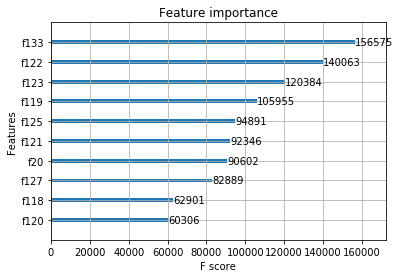

In [91]:
xgb.plot_importance(full_pipeline_m['rfm'],max_num_features = 10)
plt.rcParams['figure.figsize'] = [16, 16]
plt.show()

# Predictions

In [31]:
test_data = pd.read_csv('test.csv')
test_data.head()

,Id,Product_Info_1,Product_Info_2,Product_Info_3,Product_Info_4,Product_Info_5,Product_Info_6,Product_Info_7,Ins_Age,Ht,...,Medical_Keyword_39,Medical_Keyword_40,Medical_Keyword_41,Medical_Keyword_42,Medical_Keyword_43,Medical_Keyword_44,Medical_Keyword_45,Medical_Keyword_46,Medical_Keyword_47,Medical_Keyword_48
0,1,1,D3,26,0.487179,2,3,1,0.611940,0.781818,...,0,0,0,0,0,0,0,0,0,0
1,3,1,A2,26,0.076923,2,3,1,0.626866,0.727273,...,0,0,0,0,0,0,0,0,0,0
2,4,1,D3,26,0.144667,2,3,1,0.582090,0.709091,...,0,0,0,0,0,0,0,0,0,0
3,9,1,A1,26,0.151709,2,1,1,0.522388,0.654545,...,0,0,0,0,0,0,0,0,1,1
4,12,1,A1,26,0.076923,2,3,1,0.298507,0.672727,...,0,0,0,0,0,0,0,0,0,0


In [32]:
y_pred = full_pipeline_m.predict( test_data ) 

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:844: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

In [33]:
len(y_pred) #19765

19765

In [34]:
#creating dataframe to save into proper format
pred_res = pd.DataFrame(y_pred, columns = ['Response'])
pred_id = test_data['Id']
final = pd.concat([pred_id,pred_res], axis = 1)
final

In [37]:
final.to_csv('prudential_pred.csv',index = False, header = True)

----

# Next steps, implementing grid search into pipeline
- Currently there is a fittransform error from the GridSearch's scoring

In [508]:
# Do not run
X = data.drop('Response', axis = 1)
y = data['Response'].values 

X_train, X_test, y_train, y_test = train_test_split( X, y , test_size = 0.2 , random_state = 42 )

#The full pipeline as a step in another pipeline with an estimator as the final step
full_pipeline_m = Pipeline( steps = [ 
    ( 'full_pipeline', full_pipeline),
    ('rfm',XGBClassifier(n_jobs = -1,))
#     ('rfm', RandomForestClassifier(random_state = 0, class_weight = 'balanced')),
# ( 'model', RandomForestClassifier(n_jobs = -1,verbose = 1, random_state = 0, class_weight = 'balanced'),) #score = 0.41, 0.50933
] )

#Grid search

grid = {'rfm__max_depth': [2, 6, 10], 
         'rfm__min_samples_split': [5, 10]
       }

# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=full_pipeline_m, 
                          param_grid=grid, 
                          scoring=cohen, 
                          cv=5,
#                           error_score = 0,
#                           refit = False
                         )

# Fit using grid search
# gridsearch.fit(X_train, y_train)

# Calculate the test score
# gridsearch.score(X_test, y_test)

#Can call fit on it just like any other pipeline
# full_pipeline_m.fit( X_train, y_train )

#Can predict with it like any other pipeline
# y_pred = full_pipeline_m.predict( X_test ) 
# y_pred = gridsearch.predict( X_test ) 
                        

# Another next step: Mission of getting the important features' names 

In [16]:
import xgboost as xgb

In [17]:
import matplotlib.pyplot as plt

In [24]:
print(full_pipeline_m.named_steps["rfm"].feature_importances_)

[0.01010036 0.00437335 0.00638613 0.00402752 0.00668538 0.00436523
 0.         0.00416128 0.00443942 0.01883804 0.00336411 0.00433515
 0.01486567 0.011138   0.01198572 0.00391592 0.00980122 0.00367338
 0.00310102 0.00480563 0.00341944 0.00435238 0.03712924 0.01611847
 0.00647504 0.00696166 0.0048858  0.00366417 0.00944866 0.00521111
 0.00705771 0.00507368 0.00384979 0.00818194 0.00781101 0.00613259
 0.0106976  0.00417812 0.00625978 0.01449963 0.00381481 0.00853573
 0.00900088 0.00372942 0.01692121 0.01087124 0.00645911 0.00400743
 0.00650438 0.00518068 0.01015138 0.00803514 0.02248611 0.00338265
 0.00476721 0.00500423 0.00547179 0.00347732 0.00690357 0.00892792
 0.00446831 0.00408059 0.00614647 0.00440308 0.00568416 0.00543733
 0.00561155 0.00543822 0.00611986 0.00414895 0.00360847 0.00365484
 0.00457363 0.00543128 0.00392229 0.05657213 0.00580435 0.00590406
 0.0059951  0.005959   0.00444816 0.005534   0.00588788 0.00585536
 0.00954679 0.00583403 0.04370526 0.00515741 0.00496884 0.0065

In [60]:
d = pd.read_csv('train.csv')

In [61]:
d.drop(['Insurance_History_4','Insurance_History_7','Insurance_History_9','Medical_History_26','Medical_History_36'],inplace = True, axis = 1)

In [58]:
for i in ['Insurance_History_4','Insurance_History_7','Insurance_History_9','Medical_History_26','Medical_History_36']:
    cats.remove(i)

In [62]:
pd.get_dummies(data = d, columns = cats, prefix = cats, drop_first = True)

,Id,Product_Info_4,Ins_Age,Ht,Wt,BMI,Employment_Info_1,Employment_Info_4,Employment_Info_6,Insurance_History_5,...,Medical_History_35_3,Medical_History_37_2,Medical_History_37_3,Medical_History_38_2,Medical_History_39_2,Medical_History_39_3,Medical_History_40_2,Medical_History_40_3,Medical_History_41_2,Medical_History_41_3
0,2,0.076923,0.641791,0.581818,0.148536,0.323008,0.028,0.00000,NaN,0.000667,...,0,1,0,0,0,1,0,1,0,1
1,5,0.076923,0.059701,0.600000,0.131799,0.272288,0.000,0.00000,0.0018,0.000133,...,0,1,0,0,0,1,0,1,0,0
2,6,0.076923,0.029851,0.745455,0.288703,0.428780,0.030,0.00000,0.0300,NaN,...,0,1,0,0,0,1,0,1,0,0
3,7,0.487179,0.164179,0.672727,0.205021,0.352438,0.042,0.00000,0.2000,NaN,...,0,1,0,0,0,1,0,1,0,0
4,8,0.230769,0.417910,0.654545,0.234310,0.424046,0.027,0.00000,0.0500,NaN,...,0,1,0,0,0,1,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59376,79142,0.230769,0.074627,0.709091,0.320084,0.519103,0.020,0.00000,0.0250,NaN,...,0,1,0,0,0,1,0,1,0,1
59377,79143,0.230769,0.432836,0.800000,0.403766,0.551119,0.100,0.00001,0.3500,0.000267,...,0,1,0,0,0,1,0,1,0,0
59378,79144,0.076923,0.104478,0.745455,0.246862,0.360969,0.035,0.00000,NaN,NaN,...,0,1,0,0,0,1,0,1,0,0
59379,79145,0.230769,0.507463,0.690909,0.276151,0.462452,0.038,NaN,NaN,NaN,...,0,1,0,0,0,1,0,1,0,1


In [63]:
# d.drop(['Insurance_History_4','Insurance_History_7','Insurance_History_9','Medical_History_26','Medical_History_36'],inplace = True, axis = 1)
d.drop(['Medical_Keyword_11','Medical_Keyword_23','Medical_Keyword_48'],inplace = True, axis = 1)


In [66]:
d.columns[]

'Family_Hist_4'

Pipeline Source: https://towardsdatascience.com/custom-transformers-and-ml-data-pipelines-with-python-20ea2a7adb65